# Notebook 1 -- Nettoyage des donnees et analyse exploratoire

## Contexte

Ce notebook constitue la premiere etape de notre analyse des scores ESG (Environmental, Social, Governance) 
pour un panel de 23 entreprises technologiques et innovantes cotees en bourse. Les donnees proviennent 
du terminal Bloomberg (scores BESG) et couvrent la periode 2016-2026 avec une frequence mensuelle.

L'objectif est de reproduire et d'ameliorer la methodologie presentee dans le paper de reference 
("K-means et analyse de clustering hierarchique agglomeratif des scores ESG") en l'appliquant 
a un univers d'investissement different : les entreprises liees a l'intelligence artificielle et 
aux semi-conducteurs, plutot que le secteur de l'energie.

## Structure de ce notebook

1. Chargement et inspection des donnees brutes
2. Nettoyage : conversion des formats (dates Excel, separateurs decimaux, valeurs manquantes)
3. Restructuration en format exploitable (panel long)
4. Statistiques descriptives
5. Analyse des valeurs manquantes
6. Visualisations exploratoires (evolution temporelle, distributions, correlations)

## Fichiers sources

- `data/ENVIRONMENTAL_SCORE.csv` : BESG Environmental Pillar Score
- `data/SOCIAL_SCORE.csv` : BESG Social Pillar Score
- `data/esg score.csv` : BESG ESG Score (score composite)

---
## 1. Imports et configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Configuration graphique
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_style('whitegrid')

# Chemin vers les donnees
DATA_DIR = '../data/'

print('Imports effectues avec succes.')

Imports effectues avec succes.


---
## 2. Chargement des donnees brutes

Les fichiers CSV exportes depuis Bloomberg ont un format particulier :
- Les 10 premieres lignes contiennent des metadonnees (titre, dates de debut/fin, tickers, noms de champs)
- Les donnees effectives commencent a la ligne 11
- La premiere colonne est vide, la deuxieme contient les dates au format numerique Excel
- Les scores utilisent la virgule comme separateur decimal (format francais)
- Les valeurs manquantes sont codees `#N/A N/A`

In [3]:
def charger_csv_bloomberg(filepath, nom_score):
    """
    Charge un fichier CSV exporte depuis Bloomberg et le nettoie.
    
    Parametres
    ----------
    filepath : str
        Chemin vers le fichier CSV.
    nom_score : str
        Nom du type de score (ex: 'Environmental', 'Social', 'ESG').
    
    Retourne
    --------
    pd.DataFrame
        DataFrame nettoye en format long avec colonnes : Date, Ticker, Score, Type.
    """
    # Lecture brute : on saute les 9 premieres lignes de metadonnees
    # La ligne 10 (index 9) contient 'Dates' et les noms de colonnes
    raw = pd.read_csv(
        filepath,
        header=None,
        skiprows=10,
        na_values=['#N/A N/A', '#N/A', 'N/A', ''],
        encoding='utf-8'
    )
    
    # Lecture de la ligne d'en-tete avec les tickers (ligne 8, index 7)
    header_raw = pd.read_csv(filepath, header=None, nrows=10, encoding='utf-8')
    tickers = header_raw.iloc[7, 2:].values  # Les tickers commencent a la colonne 2
    
    # Construction du DataFrame
    # Colonne 0 : vide, Colonne 1 : Dates, Colonnes 2+ : scores par entreprise
    df = raw.iloc[:, 1:].copy()
    df.columns = ['Date_Excel'] + list(tickers)
    
    print(f"[{nom_score}] Dimensions brutes : {df.shape[0]} lignes x {df.shape[1]-1} entreprises")
    print(f"[{nom_score}] Periode : date Excel {df['Date_Excel'].iloc[0]} a {df['Date_Excel'].iloc[-1]}")
    
    return df, tickers


# Chargement des trois fichiers
df_env_raw, tickers_env = charger_csv_bloomberg(DATA_DIR + 'ENVIRONMENTAL_SCORE.csv', 'Environmental')
df_soc_raw, tickers_soc = charger_csv_bloomberg(DATA_DIR + 'SOCIAL_SCORE.csv', 'Social')
df_esg_raw, tickers_esg = charger_csv_bloomberg(DATA_DIR + 'esg score.csv', 'ESG')

[Environmental] Dimensions brutes : 122 lignes x 23 entreprises
[Environmental] Periode : date Excel 42369 a 46052
[Social] Dimensions brutes : 122 lignes x 23 entreprises
[Social] Periode : date Excel 42369 a 46052
[ESG] Dimensions brutes : 122 lignes x 23 entreprises
[ESG] Periode : date Excel 42369 a 46052


In [4]:
# Verification : les tickers sont-ils identiques dans les 3 fichiers ?
print("Tickers Environmental :", list(tickers_env))
print("\nTickers Social :", list(tickers_soc))
print("\nTickers ESG :", list(tickers_esg))
print("\nTickers identiques dans les 3 fichiers :", 
      np.array_equal(tickers_env, tickers_soc) and np.array_equal(tickers_soc, tickers_esg))

Tickers Environmental : ['NVDA US Equity', 'AVGO US Equity', 'TSM US Equity', 'GOOGL US Equity', '000660 KS Equity', 'LRCX US Equity', '6857 JP Equity', 'TSEM IT Equity', 'MSFT US Equity', 'LITE US Equity', 'AMD US Equity', 'FN US Equity', 'SNOW US Equity', 'MU US Equity', 'TSLA US Equity', '9984 JP Equity', 'CRDO US Equity', 'ENR GR Equity', 'MPWR US Equity', '2383 TT Equity', 'CLS CN Equity', 'META US Equity', 'AMZN US Equity']

Tickers Social : ['NVDA US Equity', 'AVGO US Equity', 'TSM US Equity', 'GOOGL US Equity', '000660 KS Equity', 'LRCX US Equity', '6857 JP Equity', 'TSEM IT Equity', 'MSFT US Equity', 'LITE US Equity', 'AMD US Equity', 'FN US Equity', 'SNOW US Equity', 'MU US Equity', 'TSLA US Equity', '9984 JP Equity', 'CRDO US Equity', 'ENR GR Equity', 'MPWR US Equity', '2383 TT Equity', 'CLS CN Equity', 'META US Equity', 'AMZN US Equity']

Tickers ESG : ['NVDA US Equity', 'AVGO US Equity', 'TSM US Equity', 'GOOGL US Equity', '000660 KS Equity', 'LRCX US Equity', '6857 JP Equ

In [5]:
# Apercu des donnees brutes (avant nettoyage)
print("=== Apercu Environmental Score (brut) ===")
df_env_raw.head()

=== Apercu Environmental Score (brut) ===


,Date_Excel,NVDA US Equity,AVGO US Equity,TSM US Equity,GOOGL US Equity,000660 KS Equity,LRCX US Equity,6857 JP Equity,TSEM IT Equity,MSFT US Equity,...,MU US Equity,TSLA US Equity,9984 JP Equity,CRDO US Equity,ENR GR Equity,MPWR US Equity,2383 TT Equity,CLS CN Equity,META US Equity,AMZN US Equity
0,42369,NaN,NaN,"3,43","3,96","2,94",NaN,NaN,0,NaN,...,NaN,"1,65",NaN,NaN,NaN,0,NaN,"2,43","2,64","0,31"
1,42398,"6,48",NaN,"3,43","3,96","2,94",NaN,NaN,0,NaN,...,NaN,"1,65",NaN,NaN,NaN,0,NaN,"2,43","2,64","0,31"
2,42429,"6,48",NaN,"3,43","3,96","2,94",NaN,NaN,0,NaN,...,NaN,"1,65",NaN,NaN,NaN,0,NaN,"2,43","2,64","0,31"
3,42460,"6,48",NaN,"3,43","3,96","2,94",NaN,"5,39",0,NaN,...,NaN,"1,65","1,84",NaN,NaN,0,NaN,"2,43","2,64","0,31"
4,42489,"6,48",NaN,"3,43","3,96","2,94",NaN,"5,39",0,NaN,...,NaN,"1,65","1,84",NaN,NaN,0,NaN,"2,43","2,64","0,31"


---
## 3. Nettoyage des donnees

### 3.1 Conversion des dates

Les dates sont au format numerique Excel (nombre de jours depuis le 30 decembre 1899). 
Par exemple, 42369 correspond au 1er janvier 2016.

### 3.2 Conversion des separateurs decimaux

Les scores utilisent la virgule comme separateur decimal (ex: `"3,43"` pour 3.43). 
Il faut remplacer les virgules par des points puis convertir en float.

### 3.3 Traitement des valeurs manquantes

Les `NaN` de Bloomberg indiquent que le score n'etait pas encore disponible pour cette entreprise 
a cette date. C'est un phenomene courant : les scores ESG ne sont pas calcules des l'introduction 
en bourse, ils apparaissent progressivement au fil du temps.

In [6]:
def excel_date_to_datetime(excel_date):
    """
    Convertit une date au format numerique Excel en datetime Python.
    La base Excel est le 30 decembre 1899 (convention Windows).
    """
    base = datetime(1899, 12, 30)
    return base + timedelta(days=int(excel_date))


def nettoyer_scores(df, nom_score):
    """
    Nettoie un DataFrame brut de scores Bloomberg :
    - Convertit les dates Excel en datetime
    - Remplace les virgules par des points dans les scores
    - Convertit les scores en float
    - Gere les valeurs manquantes
    
    Parametres
    ----------
    df : pd.DataFrame
        DataFrame brut avec Date_Excel + colonnes de scores.
    nom_score : str
        Type de score pour le nommage.
    
    Retourne
    --------
    pd.DataFrame
        DataFrame nettoye avec dates converties et scores en float.
    """
    df_clean = df.copy()
    
    # Conversion des dates
    df_clean['Date'] = df_clean['Date_Excel'].apply(excel_date_to_datetime)
    df_clean = df_clean.drop(columns=['Date_Excel'])
    
    # Conversion des scores : remplacer virgule par point puis convertir en float
    score_cols = [c for c in df_clean.columns if c != 'Date']
    for col in score_cols:
        # Certaines valeurs sont deja numeriques (int ou float), d'autres sont des strings
        df_clean[col] = df_clean[col].apply(
            lambda x: float(str(x).replace(',', '.')) if pd.notna(x) and str(x).strip() != '' else np.nan
        )
    
    # Reordonner les colonnes
    df_clean = df_clean[['Date'] + score_cols]
    
    # Statistiques de nettoyage
    n_total = df_clean[score_cols].size
    n_missing = df_clean[score_cols].isna().sum().sum()
    pct_missing = 100 * n_missing / n_total
    print(f"[{nom_score}] Apres nettoyage : {n_missing}/{n_total} valeurs manquantes ({pct_missing:.1f}%)")
    print(f"[{nom_score}] Periode : {df_clean['Date'].min().strftime('%Y-%m-%d')} a {df_clean['Date'].max().strftime('%Y-%m-%d')}")
    
    return df_clean


# Application du nettoyage
df_env = nettoyer_scores(df_env_raw, 'Environmental')
df_soc = nettoyer_scores(df_soc_raw, 'Social')
df_esg = nettoyer_scores(df_esg_raw, 'ESG')

[Environmental] Apres nettoyage : 377/2806 valeurs manquantes (13.4%)
[Environmental] Periode : 2015-12-31 a 2026-01-30
[Social] Apres nettoyage : 377/2806 valeurs manquantes (13.4%)
[Social] Periode : 2015-12-31 a 2026-01-30
[ESG] Apres nettoyage : 377/2806 valeurs manquantes (13.4%)
[ESG] Periode : 2015-12-31 a 2026-01-30


In [7]:
# Apercu apres nettoyage
print("=== Environmental Score (nettoye) ===")
df_env.head()

=== Environmental Score (nettoye) ===


,Date,NVDA US Equity,AVGO US Equity,TSM US Equity,GOOGL US Equity,000660 KS Equity,LRCX US Equity,6857 JP Equity,TSEM IT Equity,MSFT US Equity,...,MU US Equity,TSLA US Equity,9984 JP Equity,CRDO US Equity,ENR GR Equity,MPWR US Equity,2383 TT Equity,CLS CN Equity,META US Equity,AMZN US Equity
0,2015-12-31,NaN,NaN,3.43,3.96,2.94,NaN,NaN,0.0,NaN,...,NaN,1.65,NaN,NaN,NaN,0.0,NaN,2.43,2.64,0.31
1,2016-01-29,6.48,NaN,3.43,3.96,2.94,NaN,NaN,0.0,NaN,...,NaN,1.65,NaN,NaN,NaN,0.0,NaN,2.43,2.64,0.31
2,2016-02-29,6.48,NaN,3.43,3.96,2.94,NaN,NaN,0.0,NaN,...,NaN,1.65,NaN,NaN,NaN,0.0,NaN,2.43,2.64,0.31
3,2016-03-31,6.48,NaN,3.43,3.96,2.94,NaN,5.39,0.0,NaN,...,NaN,1.65,1.84,NaN,NaN,0.0,NaN,2.43,2.64,0.31
4,2016-04-29,6.48,NaN,3.43,3.96,2.94,NaN,5.39,0.0,NaN,...,NaN,1.65,1.84,NaN,NaN,0.0,NaN,2.43,2.64,0.31


In [8]:
print("=== Social Score (nettoye) ===")
df_soc.head()

=== Social Score (nettoye) ===


,Date,NVDA US Equity,AVGO US Equity,TSM US Equity,GOOGL US Equity,000660 KS Equity,LRCX US Equity,6857 JP Equity,TSEM IT Equity,MSFT US Equity,...,MU US Equity,TSLA US Equity,9984 JP Equity,CRDO US Equity,ENR GR Equity,MPWR US Equity,2383 TT Equity,CLS CN Equity,META US Equity,AMZN US Equity
0,2015-12-31,NaN,NaN,3.61,0.71,2.84,NaN,NaN,1.03,NaN,...,NaN,3.17,NaN,NaN,NaN,1.62,NaN,1.54,0.77,1.26
1,2016-01-29,3.49,NaN,3.61,0.71,2.84,NaN,NaN,1.03,NaN,...,NaN,3.17,NaN,NaN,NaN,1.62,NaN,1.54,0.77,1.26
2,2016-02-29,3.49,NaN,3.61,0.71,2.84,NaN,NaN,1.03,NaN,...,NaN,3.17,NaN,NaN,NaN,1.62,NaN,1.54,0.77,1.26
3,2016-03-31,3.49,NaN,3.61,0.71,2.84,NaN,1.62,1.03,NaN,...,NaN,3.17,1.7,NaN,NaN,1.62,NaN,1.54,0.77,1.26
4,2016-04-29,3.49,NaN,3.61,0.71,2.84,NaN,1.62,1.03,NaN,...,NaN,3.17,1.7,NaN,NaN,1.62,NaN,1.54,0.77,1.26


In [9]:
print("=== ESG Score global (nettoye) ===")
df_esg.head()

=== ESG Score global (nettoye) ===


,Date,NVDA US Equity,AVGO US Equity,TSM US Equity,GOOGL US Equity,000660 KS Equity,LRCX US Equity,6857 JP Equity,TSEM IT Equity,MSFT US Equity,...,MU US Equity,TSLA US Equity,9984 JP Equity,CRDO US Equity,ENR GR Equity,MPWR US Equity,2383 TT Equity,CLS CN Equity,META US Equity,AMZN US Equity
0,2015-12-31,NaN,NaN,4.05,2.76,3.47,NaN,NaN,1.67,NaN,...,NaN,3.03,NaN,NaN,NaN,1.93,NaN,2.93,2.28,1.89
1,2016-01-29,5.66,NaN,4.05,2.76,3.47,NaN,NaN,1.67,NaN,...,NaN,3.03,NaN,NaN,NaN,1.93,NaN,2.93,2.28,1.89
2,2016-02-29,5.66,NaN,4.05,2.76,3.47,NaN,NaN,1.67,NaN,...,NaN,3.03,NaN,NaN,NaN,1.93,NaN,2.93,2.28,1.89
3,2016-03-31,5.66,NaN,4.05,2.76,3.47,NaN,3.74,1.67,NaN,...,NaN,3.03,2.4,NaN,NaN,1.93,NaN,2.93,2.28,1.89
4,2016-04-29,5.66,NaN,4.05,2.76,3.47,NaN,3.74,1.67,NaN,...,NaN,3.03,2.4,NaN,NaN,1.93,NaN,2.93,2.28,1.89


---
## 4. Restructuration en format long (panel)

Pour faciliter les analyses statistiques et les visualisations, on transforme les DataFrames 
du format large (une colonne par entreprise) au format long (une ligne par observation date/entreprise). 
On fusionne ensuite les trois types de scores dans un seul DataFrame panel.

In [10]:
def wide_to_long(df, score_type):
    """
    Transforme un DataFrame wide en format long.
    
    Parametres
    ----------
    df : pd.DataFrame
        DataFrame en format large (Date + colonnes de scores par ticker).
    score_type : str
        Nom du type de score.
    
    Retourne
    --------
    pd.DataFrame
        Format long avec colonnes : Date, Ticker, Score.
    """
    score_cols = [c for c in df.columns if c != 'Date']
    df_long = df.melt(id_vars='Date', value_vars=score_cols,
                      var_name='Ticker', value_name=score_type)
    return df_long


# Transformation en format long
df_env_long = wide_to_long(df_env, 'Env_Score')
df_soc_long = wide_to_long(df_soc, 'Soc_Score')
df_esg_long = wide_to_long(df_esg, 'ESG_Score')

# Fusion des trois scores dans un seul DataFrame panel
df_panel = df_env_long.merge(df_soc_long, on=['Date', 'Ticker'], how='outer')
df_panel = df_panel.merge(df_esg_long, on=['Date', 'Ticker'], how='outer')

# Tri par ticker puis par date
df_panel = df_panel.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"Dimensions du panel : {df_panel.shape}")
print(f"Nombre d'entreprises : {df_panel['Ticker'].nunique()}")
print(f"Nombre de dates : {df_panel['Date'].nunique()}")
df_panel.head(10)

Dimensions du panel : (2806, 5)
Nombre d'entreprises : 23
Nombre de dates : 122


,Date,Ticker,Env_Score,Soc_Score,ESG_Score
0,2015-12-31,000660 KS Equity,2.94,2.84,3.47
1,2016-01-29,000660 KS Equity,2.94,2.84,3.47
2,2016-02-29,000660 KS Equity,2.94,2.84,3.47
3,2016-03-31,000660 KS Equity,2.94,2.84,3.47
4,2016-04-29,000660 KS Equity,2.94,2.84,3.47
5,2016-05-31,000660 KS Equity,2.94,2.84,3.47
6,2016-06-30,000660 KS Equity,2.94,2.84,3.47
7,2016-07-29,000660 KS Equity,2.94,2.84,3.47
8,2016-08-31,000660 KS Equity,2.94,2.84,3.47
9,2016-09-30,000660 KS Equity,2.94,2.84,3.47


In [11]:
# Dictionnaire pour identifier les entreprises
TICKER_NAMES = {
    'NVDA US Equity': 'NVIDIA',
    'AVGO US Equity': 'Broadcom',
    'TSM US Equity': 'TSMC',
    'GOOGL US Equity': 'Alphabet (Google)',
    '000660 KS Equity': 'SK Hynix',
    'LRCX US Equity': 'Lam Research',
    '6857 JP Equity': 'Advantest',
    'TSEM IT Equity': 'Tower Semiconductor',
    'MSFT US Equity': 'Microsoft',
    'LITE US Equity': 'Lumentum',
    'AMD US Equity': 'AMD',
    'FN US Equity': 'Fabrinet',
    'SNOW US Equity': 'Snowflake',
    'MU US Equity': 'Micron Technology',
    'TSLA US Equity': 'Tesla',
    '9984 JP Equity': 'SoftBank',
    'CRDO US Equity': 'CREDO Technology',
    'ENR GR Equity': 'Siemens Energy',
    'MPWR US Equity': 'Monolithic Power Systems',
    '2383 TT Equity': 'Elite Material',
    'CLS CN Equity': 'Celestica',
    'META US Equity': 'Meta Platforms',
    'AMZN US Equity': 'Amazon'
}

df_panel['Entreprise'] = df_panel['Ticker'].map(TICKER_NAMES)
print("Entreprises du panel :")
for ticker, name in sorted(TICKER_NAMES.items(), key=lambda x: x[1]):
    print(f"  {ticker:25s} -> {name}")

Entreprises du panel :
  AMD US Equity             -> AMD
  6857 JP Equity            -> Advantest
  GOOGL US Equity           -> Alphabet (Google)
  AMZN US Equity            -> Amazon
  AVGO US Equity            -> Broadcom
  CRDO US Equity            -> CREDO Technology
  CLS CN Equity             -> Celestica
  2383 TT Equity            -> Elite Material
  FN US Equity              -> Fabrinet
  LRCX US Equity            -> Lam Research
  LITE US Equity            -> Lumentum
  META US Equity            -> Meta Platforms
  MU US Equity              -> Micron Technology
  MSFT US Equity            -> Microsoft
  MPWR US Equity            -> Monolithic Power Systems
  NVDA US Equity            -> NVIDIA
  000660 KS Equity          -> SK Hynix
  ENR GR Equity             -> Siemens Energy
  SNOW US Equity            -> Snowflake
  9984 JP Equity            -> SoftBank
  TSM US Equity             -> TSMC
  TSLA US Equity            -> Tesla
  TSEM IT Equity            -> Tower Semicond

---
## 5. Analyse des valeurs manquantes

L'analyse des valeurs manquantes est fondamentale avant toute modelisation. 
Dans le contexte des scores ESG Bloomberg, les valeurs manquantes ne sont generalement pas 
aleatoires (MCAR) mais structurelles : elles correspondent a des periodes ou l'entreprise 
n'avait pas encore de score BESG attribue.

On distingue :
- Les **manquantes en debut de serie** (left-censoring) : le score n'existait pas encore
- Les **manquantes sporadiques** : potentiellement des erreurs ou des periodes de recalcul

FileNotFoundError: [Errno 2] No such file or directory: '../notebooks/figures/01_missing_data_heatmap.png'

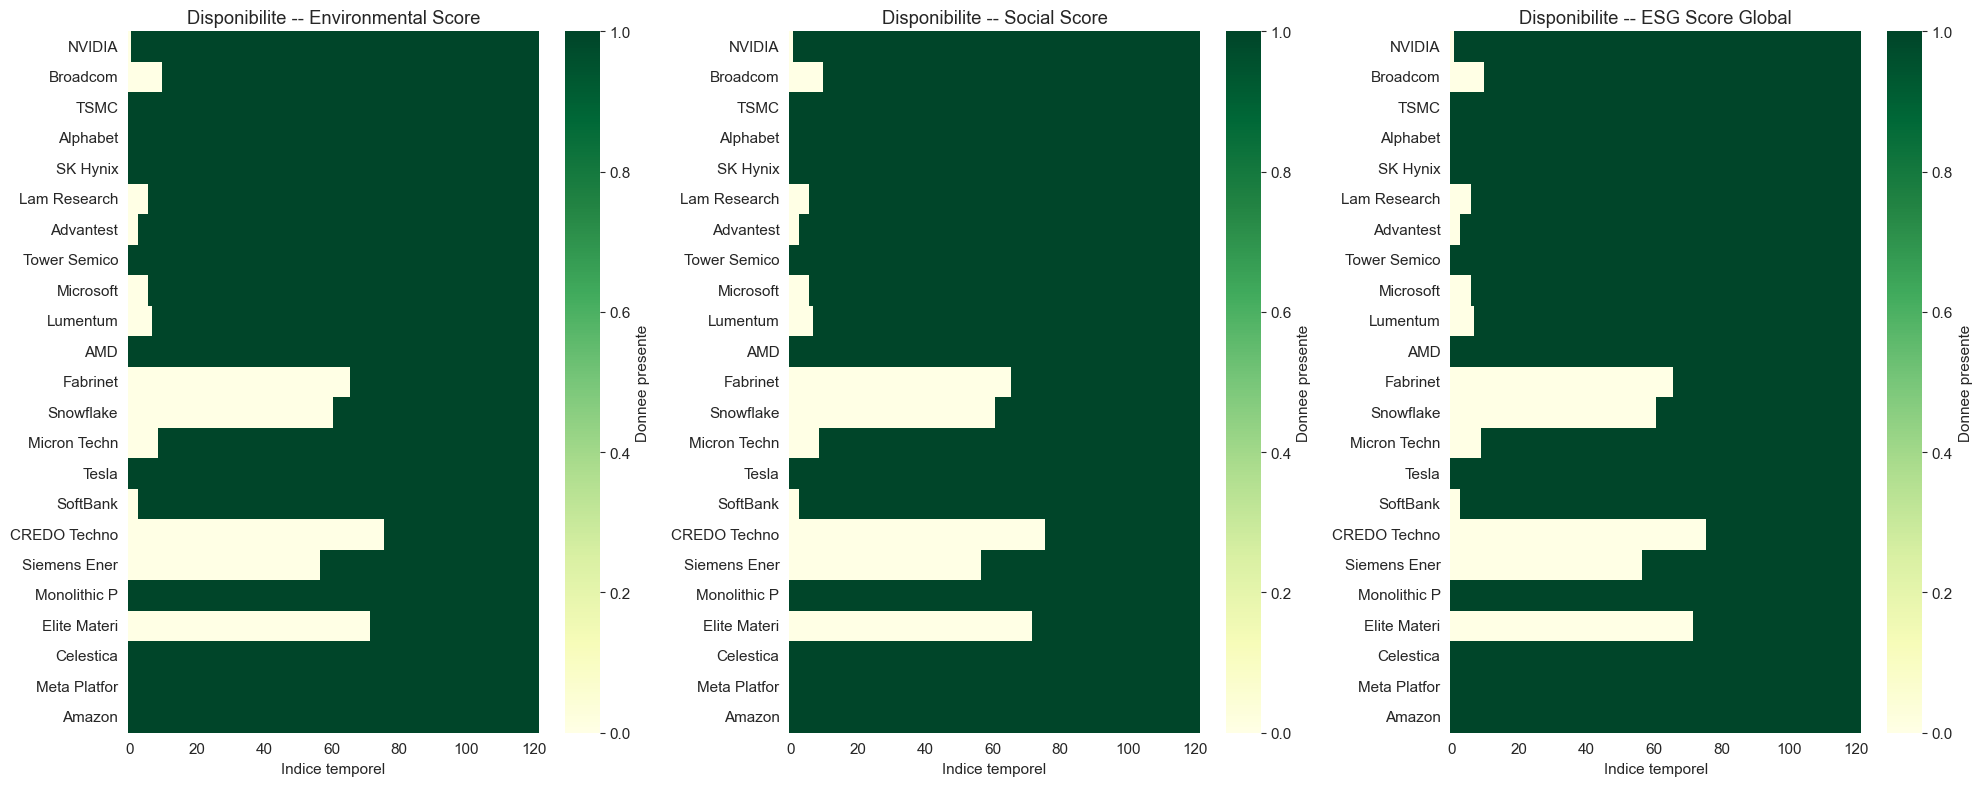

In [ ]:
# Matrice de valeurs manquantes pour chaque type de score (format wide)
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for ax, (df_w, titre) in zip(axes, [
    (df_env, 'Environmental Score'),
    (df_soc, 'Social Score'),
    (df_esg, 'ESG Score Global')
]):
    score_cols = [c for c in df_w.columns if c != 'Date']
    # Matrice binaire : 1 = present, 0 = manquant
    presence = df_w[score_cols].notna().astype(int)
    # Renommer les colonnes pour lisibilite
    presence.columns = [TICKER_NAMES.get(c, c).split('(')[0].strip()[:12] for c in presence.columns]
    
    sns.heatmap(presence.T, cmap='YlGn', cbar_kws={'label': 'Donnee presente'},
                xticklabels=20, ax=ax)
    ax.set_xlabel('Indice temporel')
    ax.set_ylabel('')
    ax.set_title(f'Disponibilite -- {titre}')

plt.tight_layout()
plt.show()
print("Figure sauvegardee : figures/01_missing_data_heatmap.png")

In [ ]:
# Pourcentage de valeurs manquantes par entreprise
missing_summary = pd.DataFrame()
for df_w, nom in [(df_env, 'Env'), (df_soc, 'Soc'), (df_esg, 'ESG')]:
    score_cols = [c for c in df_w.columns if c != 'Date']
    pct = df_w[score_cols].isna().mean() * 100
    missing_summary[nom] = pct

missing_summary.index = [TICKER_NAMES.get(c, c) for c in missing_summary.index]
missing_summary['Moyenne'] = missing_summary.mean(axis=1)
missing_summary = missing_summary.sort_values('Moyenne', ascending=False)

print("Pourcentage de valeurs manquantes par entreprise (%) :")
print(missing_summary.round(1).to_string())

Pourcentage de valeurs manquantes par entreprise (%) :
                           Env   Soc   ESG  Moyenne
CREDO Technology          62.3  62.3  62.3     62.3
Elite Material            59.0  59.0  59.0     59.0
Fabrinet                  54.1  54.1  54.1     54.1
Snowflake                 50.0  50.0  50.0     50.0
Siemens Energy            46.7  46.7  46.7     46.7
Broadcom                   8.2   8.2   8.2      8.2
Micron Technology          7.4   7.4   7.4      7.4
Lumentum                   5.7   5.7   5.7      5.7
Lam Research               4.9   4.9   4.9      4.9
Microsoft                  4.9   4.9   4.9      4.9
Advantest                  2.5   2.5   2.5      2.5
SoftBank                   2.5   2.5   2.5      2.5
NVIDIA                     0.8   0.8   0.8      0.8
AMD                        0.0   0.0   0.0      0.0
Tesla                      0.0   0.0   0.0      0.0
Tower Semiconductor        0.0   0.0   0.0      0.0
SK Hynix                   0.0   0.0   0.0      0.0
Alphabet 

In [ ]:
# Date de premiere apparition du score pour chaque entreprise
print("\nDate de premiere observation disponible par entreprise et par score :\n")
first_dates = pd.DataFrame()
for df_w, nom in [(df_env, 'Env'), (df_soc, 'Soc'), (df_esg, 'ESG')]:
    score_cols = [c for c in df_w.columns if c != 'Date']
    first = {}
    for col in score_cols:
        valid = df_w.loc[df_w[col].notna(), 'Date']
        first[col] = valid.iloc[0].strftime('%Y-%m') if len(valid) > 0 else 'N/A'
    first_dates[nom] = pd.Series(first)

first_dates.index = [TICKER_NAMES.get(c, c) for c in first_dates.index]
print(first_dates.to_string())


Date de premiere observation disponible par entreprise et par score :

                              Env      Soc      ESG
NVIDIA                    2016-01  2016-01  2016-01
Broadcom                  2016-10  2016-10  2016-10
TSMC                      2015-12  2015-12  2015-12
Alphabet (Google)         2015-12  2015-12  2015-12
SK Hynix                  2015-12  2015-12  2015-12
Lam Research              2016-06  2016-06  2016-06
Advantest                 2016-03  2016-03  2016-03
Tower Semiconductor       2015-12  2015-12  2015-12
Microsoft                 2016-06  2016-06  2016-06
Lumentum                  2016-07  2016-07  2016-07
AMD                       2015-12  2015-12  2015-12
Fabrinet                  2021-06  2021-06  2021-06
Snowflake                 2021-01  2021-01  2021-01
Micron Technology         2016-09  2016-09  2016-09
Tesla                     2015-12  2015-12  2015-12
SoftBank                  2016-03  2016-03  2016-03
CREDO Technology          2022-04  2022-04  

In [ ]:
# =============================================================================
# TRAITEMENT DES VALEURS MANQUANTES
# =============================================================================

SEUIL_MAX = 30  # % max de NaN toléré par entreprise

def traiter_missing(df, nom_score, seuil=SEUIL_MAX):
    score_cols = [c for c in df.columns if c != 'Date']
    pct_missing = df[score_cols].isna().mean() * 100
    
    # Séparer colonnes à garder vs supprimer
    cols_ok = pct_missing[pct_missing <= seuil].index.tolist()
    cols_drop = pct_missing[pct_missing > seuil].index.tolist()
    
    noms_drop = [TICKER_NAMES.get(c, c) for c in cols_drop]
    print(f"\n[{nom_score}] Entreprises supprimées ({len(cols_drop)}) : {noms_drop}")
    print(f"[{nom_score}] Entreprises conservées : {len(cols_ok)}")
    
    df_clean = df[['Date'] + cols_ok].copy()
    
    # Forward fill (les scores ESG sont annuels, on propage la dernière valeur)
    df_clean[cols_ok] = df_clean[cols_ok].ffill()
    
    # Backward fill pour les NaN en début de série
    df_clean[cols_ok] = df_clean[cols_ok].bfill()
    
    n_remaining = df_clean[cols_ok].isna().sum().sum()
    print(f"[{nom_score}] NaN restants après traitement : {n_remaining}")
    
    return df_clean

df_env_clean = traiter_missing(df_env, 'Environmental')
df_soc_clean = traiter_missing(df_soc, 'Social')
df_esg_clean = traiter_missing(df_esg, 'ESG')

# Vérification
print(f"\n--- Résumé ---")
print(f"Entreprises restantes : {len([c for c in df_esg_clean.columns if c != 'Date'])}")
print(f"Période : {df_esg_clean['Date'].min().strftime('%Y-%m-%d')} à {df_esg_clean['Date'].max().strftime('%Y-%m-%d')}")
print(f"NaN total restant : {df_esg_clean.iloc[:, 1:].isna().sum().sum()}")


[Environmental] Entreprises supprimées (5) : ['Fabrinet', 'Snowflake', 'CREDO Technology', 'Siemens Energy', 'Elite Material']
[Environmental] Entreprises conservées : 18
[Environmental] NaN restants après traitement : 0

[Social] Entreprises supprimées (5) : ['Fabrinet', 'Snowflake', 'CREDO Technology', 'Siemens Energy', 'Elite Material']
[Social] Entreprises conservées : 18
[Social] NaN restants après traitement : 0

[ESG] Entreprises supprimées (5) : ['Fabrinet', 'Snowflake', 'CREDO Technology', 'Siemens Energy', 'Elite Material']
[ESG] Entreprises conservées : 18
[ESG] NaN restants après traitement : 0

--- Résumé ---
Entreprises restantes : 18
Période : 2015-12-31 à 2026-01-30
NaN total restant : 0


In [ ]:
# Vérification des valeurs manquantes après traitement
missing_summary = pd.DataFrame()
for df_w, nom in [(df_env_clean, 'Env'), (df_soc_clean, 'Soc'), (df_esg_clean, 'ESG')]:
    score_cols = [c for c in df_w.columns if c != 'Date']
    pct = df_w[score_cols].isna().mean() * 100
    missing_summary[nom] = pct

missing_summary.index = [TICKER_NAMES.get(c, c) for c in missing_summary.index]
missing_summary['Moyenne'] = missing_summary.mean(axis=1)
missing_summary = missing_summary.sort_values('Moyenne', ascending=False)

print("Pourcentage de valeurs manquantes après traitement (%) :")
print(missing_summary.round(1).to_string())

Pourcentage de valeurs manquantes après traitement (%) :
                          Env  Soc  ESG  Moyenne
NVIDIA                    0.0  0.0  0.0      0.0
Broadcom                  0.0  0.0  0.0      0.0
Meta Platforms            0.0  0.0  0.0      0.0
Celestica                 0.0  0.0  0.0      0.0
Monolithic Power Systems  0.0  0.0  0.0      0.0
SoftBank                  0.0  0.0  0.0      0.0
Tesla                     0.0  0.0  0.0      0.0
Micron Technology         0.0  0.0  0.0      0.0
AMD                       0.0  0.0  0.0      0.0
Lumentum                  0.0  0.0  0.0      0.0
Microsoft                 0.0  0.0  0.0      0.0
Tower Semiconductor       0.0  0.0  0.0      0.0
Advantest                 0.0  0.0  0.0      0.0
Lam Research              0.0  0.0  0.0      0.0
SK Hynix                  0.0  0.0  0.0      0.0
Alphabet (Google)         0.0  0.0  0.0      0.0
TSMC                      0.0  0.0  0.0      0.0
Amazon                    0.0  0.0  0.0      0.0


In [ ]:
# =============================================================================
# CONSTRUCTION DU PANEL À PARTIR DES DONNÉES NETTOYÉES
# =============================================================================

# Récupérer les entreprises communes aux 3 scores
cols_env = [c for c in df_env_clean.columns if c != 'Date']
cols_soc = [c for c in df_soc_clean.columns if c != 'Date']
cols_esg = [c for c in df_esg_clean.columns if c != 'Date']
entreprises_communes = list(set(cols_env) & set(cols_soc) & set(cols_esg))

print(f"Entreprises communes aux 3 scores : {len(entreprises_communes)}")

# Passer en format long puis fusionner
df_env_long = df_env_clean.melt(id_vars='Date', value_vars=entreprises_communes,
                                 var_name='Ticker', value_name='Env_Score')
df_soc_long = df_soc_clean.melt(id_vars='Date', value_vars=entreprises_communes,
                                 var_name='Ticker', value_name='Soc_Score')
df_esg_long = df_esg_clean.melt(id_vars='Date', value_vars=entreprises_communes,
                                 var_name='Ticker', value_name='ESG_Score')

df_panel = df_env_long.merge(df_soc_long, on=['Date', 'Ticker']) \
                       .merge(df_esg_long, on=['Date', 'Ticker'])

# Ajouter le nom lisible
df_panel['Entreprise'] = df_panel['Ticker'].map(TICKER_NAMES)

df_panel = df_panel.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"Panel : {df_panel.shape[0]} observations, {df_panel['Ticker'].nunique()} entreprises")
print(f"Période : {df_panel['Date'].min().strftime('%Y-%m-%d')} à {df_panel['Date'].max().strftime('%Y-%m-%d')}")
print(f"NaN restants : {df_panel[['Env_Score', 'Soc_Score', 'ESG_Score']].isna().sum().sum()}")

Entreprises communes aux 3 scores : 18
Panel : 2196 observations, 18 entreprises
Période : 2015-12-31 à 2026-01-30
NaN restants : 0


---
## 6. Statistiques descriptives

On calcule les statistiques descriptives classiques (moyenne, ecart-type, min, max, quartiles) 
pour chaque type de score. Cette etape permet de detecter d'eventuelles anomalies 
(scores hors echelle, distributions atypiques) et de mieux comprendre la structure des donnees.

In [ ]:
# Statistiques descriptives globales
print("=" * 60)
print("STATISTIQUES DESCRIPTIVES DU PANEL")
print("=" * 60)

for score_col, titre in [('Env_Score', 'Environmental'), ('Soc_Score', 'Social'), ('ESG_Score', 'ESG Global')]:
    print(f"\n--- {titre} ---")
    print(df_panel[score_col].describe().round(3).to_string())

STATISTIQUES DESCRIPTIVES DU PANEL

--- Environmental ---
count    2196.000
mean        4.093
std         2.146
min         0.000
25%         2.670
50%         4.350
75%         5.730
max         7.610

--- Social ---
count    2196.000
mean        3.175
std         1.724
min         0.630
25%         1.860
50%         2.590
75%         4.390
max         7.910

--- ESG Global ---
count    2196.000
mean        4.273
std         1.396
min         1.670
25%         3.240
50%         4.190
75%         5.250
max         7.070


In [ ]:
# Statistiques descriptives par entreprise (derniere observation disponible)
# On prend le dernier score disponible pour chaque entreprise comme proxy de l'etat actuel
latest_scores = df_panel.groupby('Ticker').last().reset_index()
latest_scores['Entreprise'] = latest_scores['Ticker'].map(TICKER_NAMES)

summary_table = latest_scores[['Entreprise', 'Env_Score', 'Soc_Score', 'ESG_Score']].copy()
summary_table = summary_table.sort_values('ESG_Score', ascending=False).reset_index(drop=True)
summary_table.index = summary_table.index + 1  # Index a partir de 1

print("\nClassement des entreprises par score ESG global (derniere observation) :")
print(summary_table.to_string())


Classement des entreprises par score ESG global (derniere observation) :
                  Entreprise  Env_Score  Soc_Score  ESG_Score
1                  Advantest       7.28       6.52       7.07
2                        AMD       7.17       5.58       6.85
3                     NVIDIA       7.13       6.54       6.81
4                  Celestica       5.58       6.22       6.12
5          Micron Technology       3.98       6.06       5.63
6                       TSMC       4.57       6.31       5.48
7                  Microsoft       5.62       3.03       5.12
8                      Tesla       4.62       5.05       5.01
9               Lam Research       5.21       2.68       4.96
10                  Broadcom       4.96       2.57       4.82
11                  SK Hynix       4.41       3.29       4.66
12  Monolithic Power Systems       4.95       2.49       4.49
13                    Amazon       4.24       2.99       4.36
14         Alphabet (Google)       5.21       2.56       4

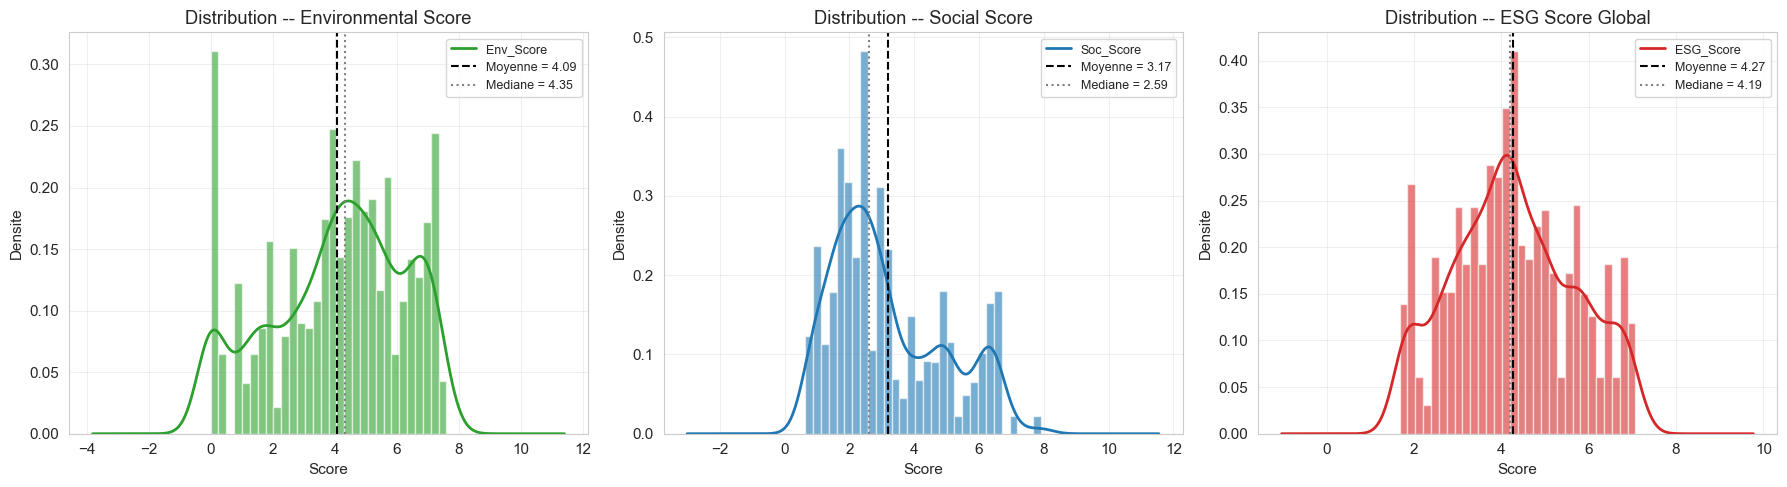

In [ ]:
# Distribution des scores (histogrammes + KDE)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (col, titre, couleur) in zip(axes, [
    ('Env_Score', 'Environmental Score', '#2ca02c'),
    ('Soc_Score', 'Social Score', '#1f77b4'),
    ('ESG_Score', 'ESG Score Global', '#d62728')
]):
    data = df_panel[col].dropna()
    ax.hist(data, bins=30, density=True, alpha=0.6, color=couleur, edgecolor='white')
    data.plot.kde(ax=ax, color=couleur, linewidth=2)
    ax.axvline(data.mean(), color='black', linestyle='--', linewidth=1.5, label=f'Moyenne = {data.mean():.2f}')
    ax.axvline(data.median(), color='gray', linestyle=':', linewidth=1.5, label=f'Mediane = {data.median():.2f}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Densite')
    ax.set_title(f'Distribution -- {titre}')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Lien entre l'analyse exploratoire et les limites identifiées dans le paper

### Limite #1 : Biais d'échelle (Domination de la variance)

L'analyse des distributions révèle des dispersions très différentes entre les trois piliers :
- **Environmental** : distribution bimodale, centrée autour de 4 (σ élevé)
- **Social** : fortement concentré sur les valeurs basses (pic à 0-1), avec une queue de distribution à droite
- **ESG Global** : distribution plus homogène, centrée sur 4-5

Ces écarts d'échelle et de dispersion entre piliers signifient que, dans un algorithme basé sur la distance euclidienne comme le K-means, **la variable avec la plus grande variance domine le calcul des distances**. Si l'on ajoute des rendements boursiers (dont la variance est encore supérieure), les scores ESG deviennent mathématiquement négligeables dans la formation des clusters.

**→ Correction appliquée :**

- **Standardisation Z-score** de toutes les variables avant clustering, afin de ramener chaque variable à une moyenne de 0 et un écart-type de 1.

- - -

### Limite #2 : Absence de structure sphérique (Échec du coude)

La bimodalité du score Environmental (deux groupes distincts d'entreprises) et l'asymétrie marquée du score Social montrent que **les données ne suivent pas une distribution gaussienne sphérique**. Or, le K-means suppose implicitement des clusters convexes et de tailles comparables.

Forcer un nombre K de clusters sur des données qui ne présentent pas cette structure revient à imposer une segmentation artificielle, comme le montre la courbe WCSS lisse observée dans le paper original.

**→ Correction appliquée :**

- **DBSCAN**, un algorithme qui détecte des clusters de formes arbitraires, identifie automatiquement le bruit (outliers), et ne nécessite pas de fixer K a priori.

---

### Limite #3 : Aveuglement aux relations non-linéaires

L'asymétrie du score Social (moyenne = 3.17 vs médiane = 2.59) indique que la relation entre les piliers ESG n'est pas symétrique. En finance, les relations entre variables sont souvent non-linéaires, asymétriques ou convexes (effet "assurance" de l'ESG en période de crise).

La corrélation de Pearson, utilisée dans le paper original, ne mesure que la dépendance linéaire. Un ρ ≈ 0 ne signifie pas absence de relation, mais absence de relation **linéaire**.

**→ Corrections appliquées :**

- **Corrélation de Spearman** (basée sur les rangs, capte les relations monotones non-linéaires)
- **ACP (Analyse en Composantes Principales)** pour visualiser les structures de dépendance multidimensionnelles sans segmentation artificielle

---

### Synthèse

L'analyse exploratoire des distributions confirme les limites méthodologiques identifiées dans le paper et motive l'application des corrections suivantes sur nos données :
1. **Standardisation Z-score** → corrige le biais d'échelle
2. **Désagrégation E / S / G** → capte les effets hétérogènes entre piliers
3. **DBSCAN + ACP** → algorithmes adaptés à la structure réelle des données
4. **Spearman** → mesure de corrélation robuste aux non-linéarités

---
## 7. Visualisation de l'evolution temporelle

L'evolution temporelle des scores ESG permet de detecter des tendances structurelles 
(amelioration ou degradation) ainsi que des ruptures potentielles 
(changement de methodologie Bloomberg, evenement externe).

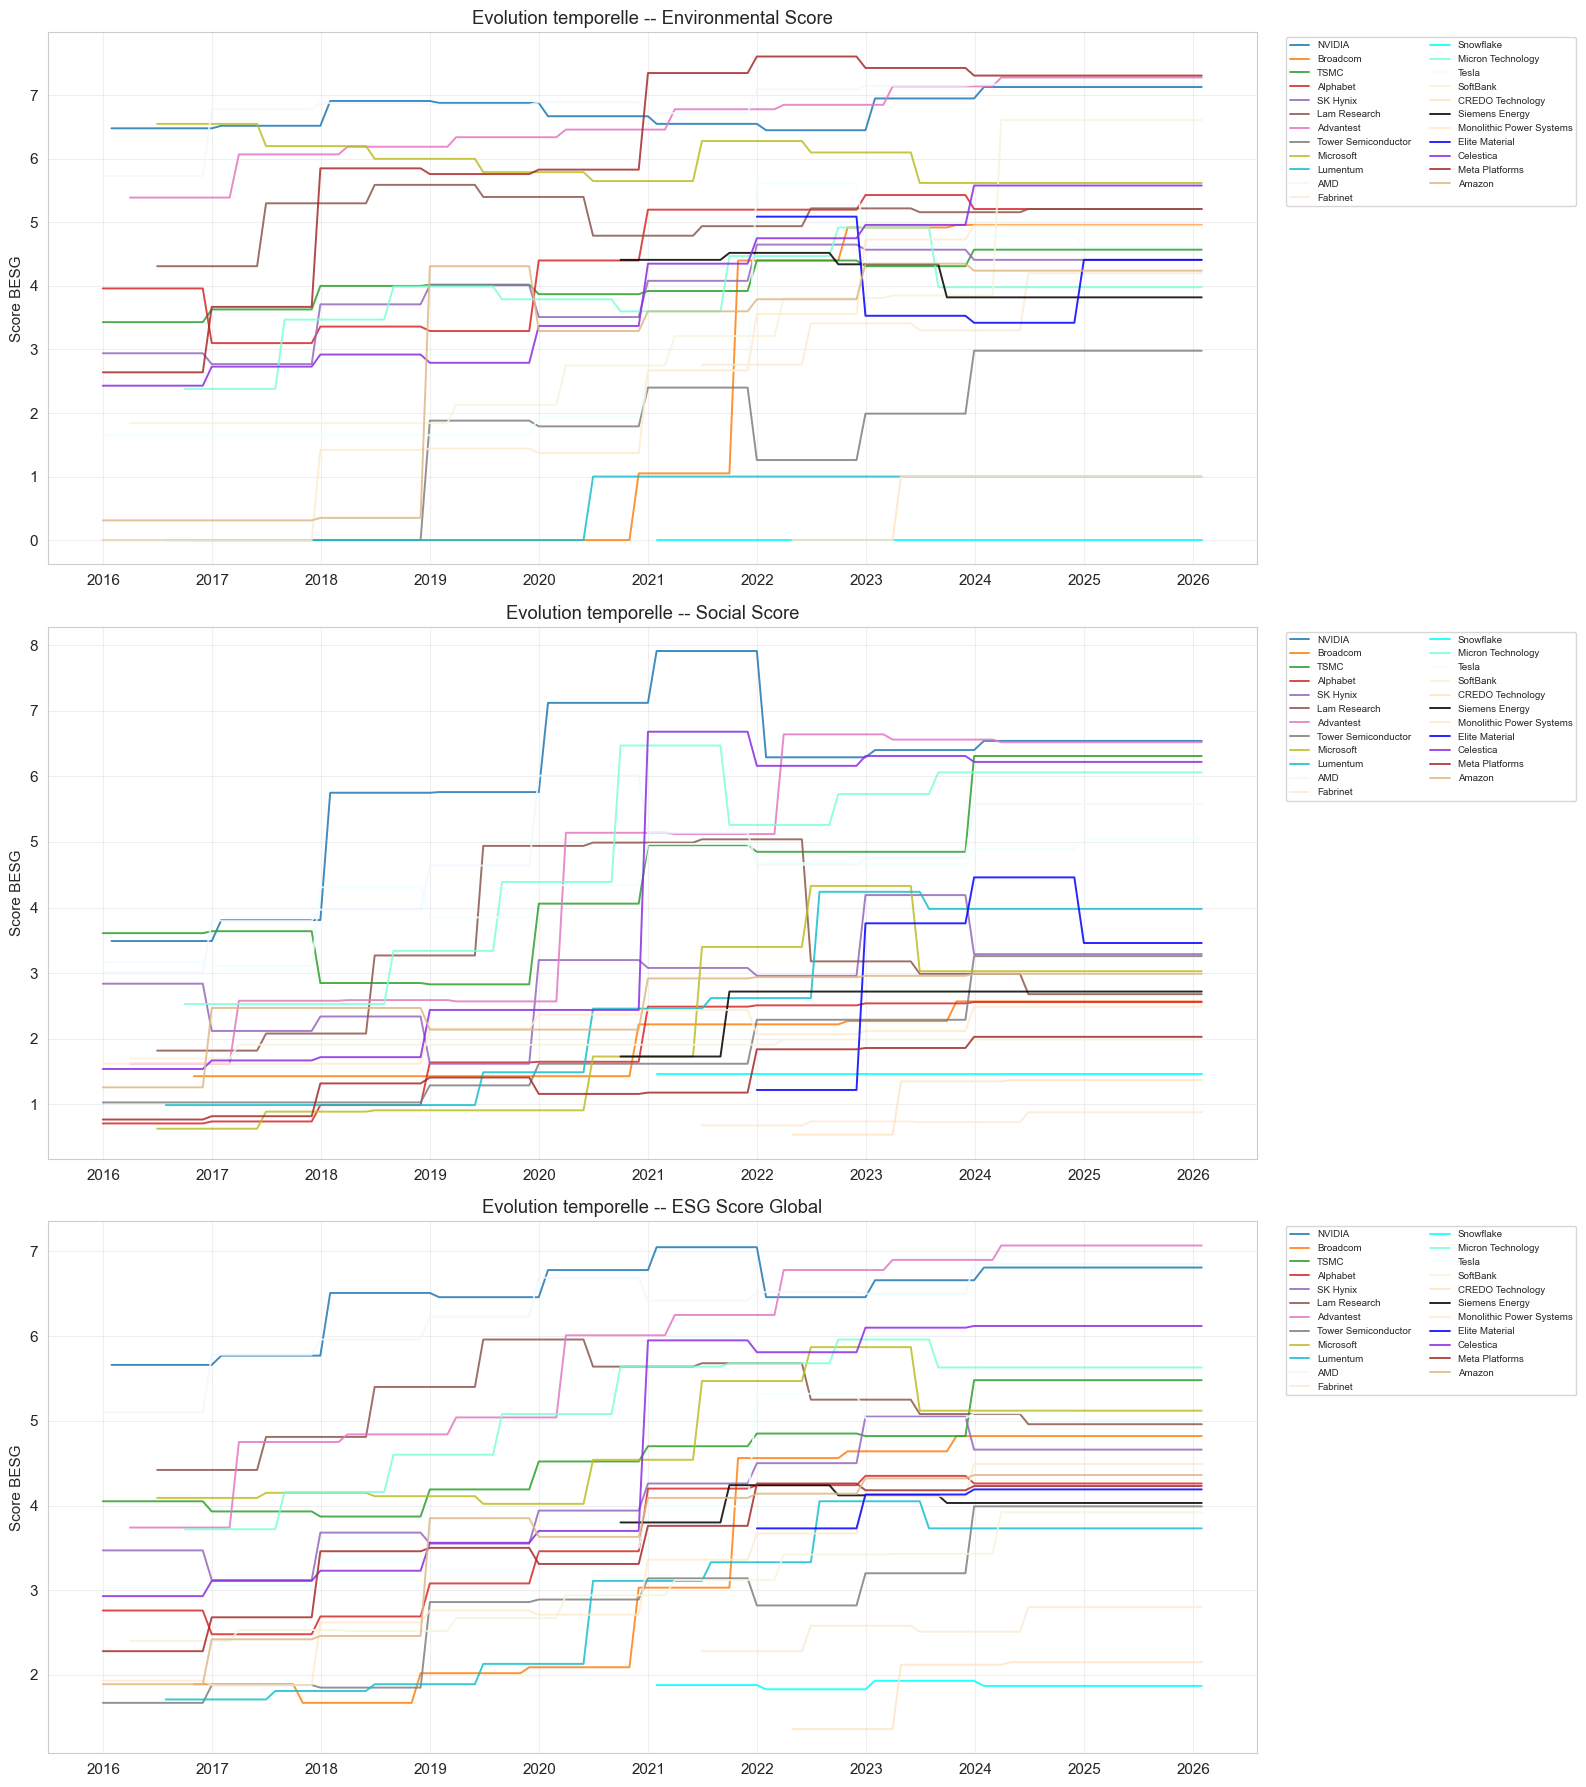

In [ ]:
import matplotlib.colors as mcolors

# Palette de couleurs bien distinctes
DISTINCT_COLORS = (
    list(mcolors.TABLEAU_COLORS.values()) +      # 10 couleurs
    list(mcolors.CSS4_COLORS.values())[:15]        # 15 supplémentaires
)

fig, axes = plt.subplots(3, 1, figsize=(16, 18))

for ax, (df_w, titre) in zip(axes, [
    (df_env, 'Environmental Score'),
    (df_soc, 'Social Score'),
    (df_esg, 'ESG Score Global')
]):
    score_cols = [c for c in df_w.columns if c != 'Date']
    
    for i, col in enumerate(score_cols):
        short_name = TICKER_NAMES.get(col, col).split('(')[0].strip()
        ax.plot(df_w['Date'], df_w[col], label=short_name,
                color=DISTINCT_COLORS[i % len(DISTINCT_COLORS)],
                alpha=0.85, linewidth=1.4)
    
    ax.set_ylabel('Score BESG')
    ax.set_title(f'Evolution temporelle -- {titre}')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7, ncol=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

## Analyse de l'évolution temporelle des scores ESG (2016-2026)

### **1. Tendance générale à la hausse**

Sur les trois piliers (Environmental, Social, ESG Global), la majorité des entreprises affichent une trajectoire ascendante sur la période 2016-2026. Cette tendance reflète la pression croissante exercée par les régulateurs, les investisseurs institutionnels et l'opinion publique pour que les entreprises du secteur technologique améliorent leurs pratiques en matière d'environnement, de responsabilité sociale et de gouvernance. On observe que les entreprises qui avaient déjà des scores élevés en début de période (comme TSMC ou SK Hynix sur l'Environmental) continuent de progresser, tandis que certaines entreprises partent de très bas et rattrapent progressivement leur retard.

### **2. Évolution par paliers (effet "escalier")**

Les scores évoluent par paliers nets et non de manière continue. Ce phénomène s'explique par la **méthodologie de Refinitiv**, qui **met à jour les scores ESG une fois par an**. Chaque marche d'escalier correspond à une réévaluation annuelle du score par l'agence de notation. Cette observation est importante car elle confirme que notre choix de **forward fill** pour l'imputation des valeurs manquantes était cohérent avec la nature même des données : entre deux mises à jour, le score ESG d'une entreprise ne change pas.

### **3. Forte hétérogénéité entre entreprises**

L'écart entre les entreprises les mieux et les moins bien notées est considérable, et ce sur les trois piliers :

- **Environmental** : certaines entreprises atteignent des scores supérieurs à 7 (TSMC, SK Hynix) tandis que d'autres stagnent en dessous de 2 sur toute la période. Cet écart ne se réduit pas significativement avec le temps, ce qui suggère que les efforts environnementaux restent très inégaux au sein du secteur technologique.

- **Social** : c'est le pilier qui présente la plus grande dispersion. On observe des entreprises regroupées autour de scores très bas (0-1) et d'autres nettement au-dessus (6-8). Cette polarisation est cohérente avec la distribution asymétrique observée dans l'analyse précédente (moyenne = 3.17, médiane = 2.59).

- **ESG Global** : les écarts sont atténués par rapport aux piliers individuels, car l'agrégation E + S + G lisse les extrêmes. Les scores se concentrent davantage dans la fourchette 3-6. **Cela illustre précisément pourquoi utiliser uniquement le score ESG global fait perdre de l'information** : les comportements très différents sur chaque pilier sont masqués par la moyenne.

### **4. Le Social : le pilier le plus volatile**

Le graphique du score Social se distingue par des sauts brutaux et fréquents. Certaines entreprises passent d'un score de 1 à 5 en une seule année, ou inversement. Cette volatilité peut s'expliquer par plusieurs facteurs :
- Des changements dans la méthodologie de notation de Refinitiv
- Des événements corporate majeurs (scandales sociaux, nouvelles politiques RH, controverses médiatiques)
- Une sensibilité plus forte de ce pilier aux événements ponctuels par rapport à l'Environmental, qui est plus structurel

Cette **volatilité du pilier Social renforce l'argument en faveur de la désagrégation E/S/G** : en agrégeant un pilier stable (E) avec un pilier volatile (S), on brouille les signaux que chacun porte individuellement.

### **5. Convergence apparente du score ESG Global**

Sur le troisième graphique, on observe que les trajectoires tendent à converger vers la fourchette 4-6 en fin de période. Cet effet de convergence est en partie un artefact de l'agrégation : les scores extrêmes sur un pilier sont compensés par des scores modérés sur un autre, ce qui ramène le score global vers le centre. **Cela confirme notre choix méthodologique de travailler avec les piliers E et S séparément plutôt qu'avec le score global, afin de ne pas perdre la richesse de l'information contenue dans chaque dimension.**

### **6. Entreprises à données tardives**

Plusieurs lignes ne démarrent qu'à partir de 2020-2022 (Snowflake, CREDO Technology, Siemens Energy, etc.). Ces entreprises correspondent exactement à celles identifiées lors de l'analyse des valeurs manquantes avec un taux de NaN supérieur à 30%. Le fait que leur historique soit tronqué confirme notre décision de les exclure de l'analyse : inclure des entreprises avec moins de la moitié de la période couverte aurait introduit un biais temporel dans le clustering, ces entreprises n'étant observées que sur une sous-période non représentative de l'ensemble.

### **Synthèse**

L'analyse temporelle met en lumière trois éléments clés pour la suite de l'étude :
1. **La désagrégation E/S/G est indispensable** : les piliers ont des dynamiques très différentes (E stable et croissant, S volatile et polarisé), qui sont masquées par le score global.
2. **La standardisation Z-score est nécessaire** : les échelles et dispersions varient fortement entre piliers, ce qui biaiserait tout algorithme de clustering basé sur les distances.
3. **L'utilisation de DBSCAN est justifiée** : la forte hétérogénéité et la présence probable d'outliers (entreprises avec des trajectoires atypiques) plaident pour un algorithme capable de gérer le bruit et des clusters de formes non sphériques.

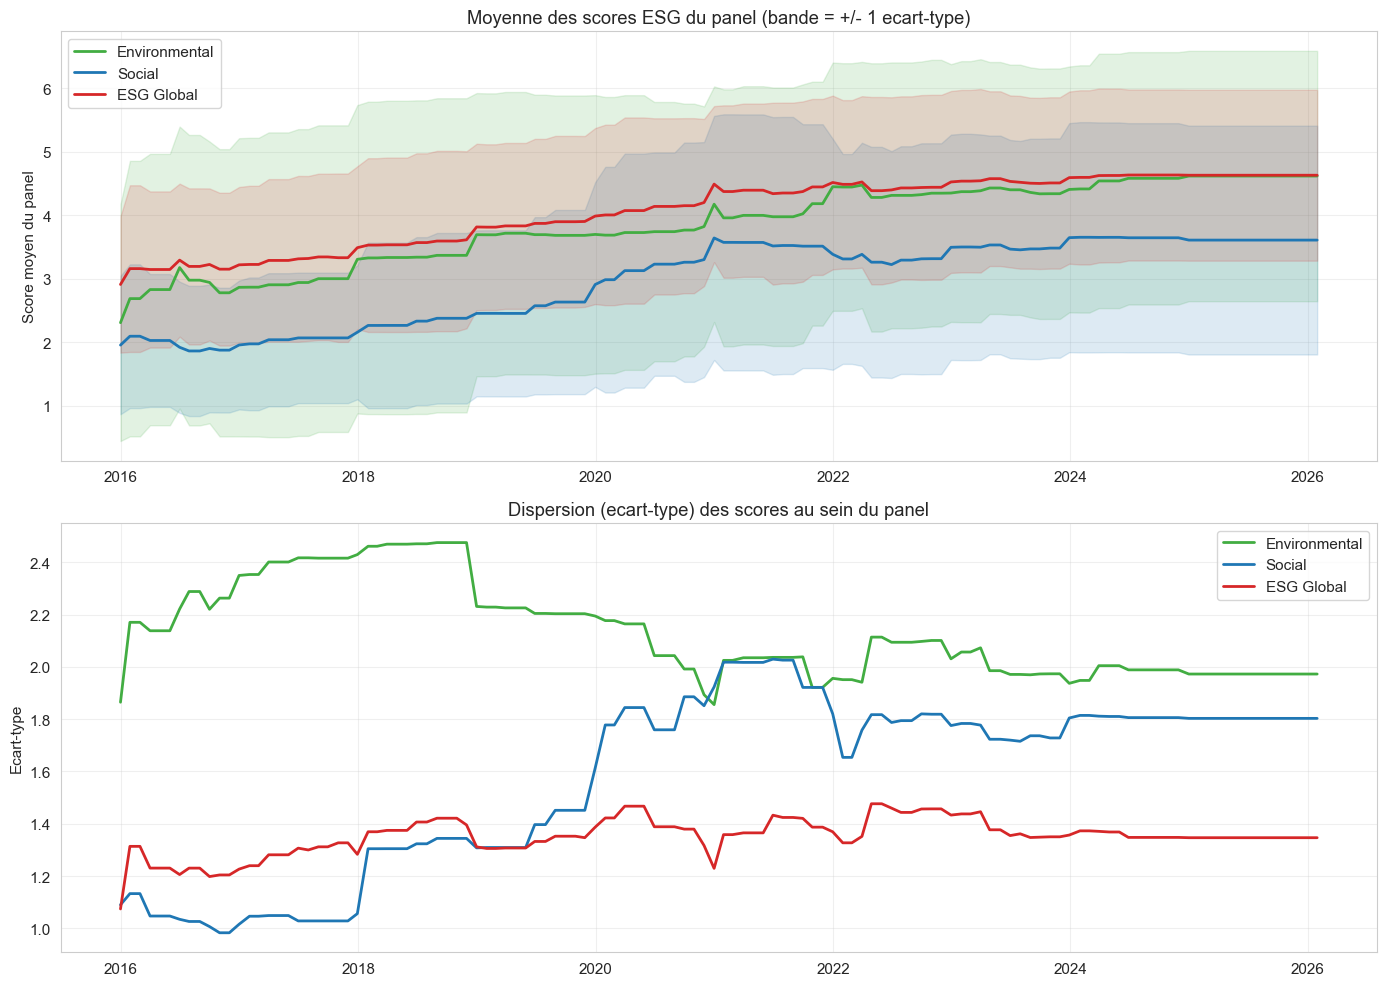

In [ ]:
# Evolution de la moyenne et de l'ecart-type du panel au cours du temps
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for df_w, titre, color in [
    (df_env, 'Environmental', "#42ad42"),
    (df_soc, 'Social', '#1f77b4'),
    (df_esg, 'ESG Global', '#d62728')
]:
    score_cols = [c for c in df_w.columns if c != 'Date']
    mean_ts = df_w[score_cols].mean(axis=1)
    std_ts = df_w[score_cols].std(axis=1)
    
    axes[0].plot(df_w['Date'], mean_ts, label=titre, color=color, linewidth=2)
    axes[0].fill_between(df_w['Date'], mean_ts - std_ts, mean_ts + std_ts, 
                          alpha=0.15, color=color)
    axes[1].plot(df_w['Date'], std_ts, label=titre, color=color, linewidth=2)

axes[0].set_ylabel('Score moyen du panel')
axes[0].set_title('Moyenne des scores ESG du panel (bande = +/- 1 ecart-type)')
axes[0].legend()
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[1].set_ylabel('Ecart-type')
axes[1].set_title('Dispersion (ecart-type) des scores au sein du panel')
axes[1].legend()
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

---
## 8. Analyse des correlations

L'etude des correlations entre les trois piliers ESG permet de verifier si les scores 
sont redondants (forte correlation) ou apportent chacun une information distincte. 
Cela a des implications directes pour la strategie de clustering : si les piliers sont 
tres correles, une reduction de dimension (ACP) sera pertinente.

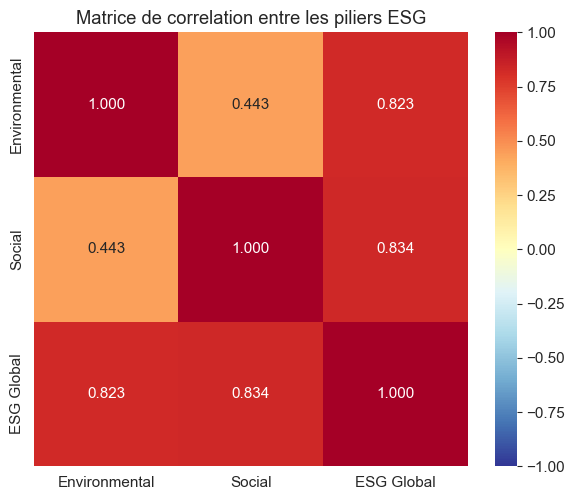


Matrice de correlation :
           Env_Score  Soc_Score  ESG_Score
Env_Score     1.0000     0.4435     0.8230
Soc_Score     0.4435     1.0000     0.8342
ESG_Score     0.8230     0.8342     1.0000


In [ ]:
# Correlation entre les trois types de scores
corr_scores = df_panel[['Env_Score', 'Soc_Score', 'ESG_Score']].corr()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr_scores, annot=True, fmt='.3f', cmap='RdYlBu_r', center=0,
            vmin=-1, vmax=1, square=True, ax=ax,
            xticklabels=['Environmental', 'Social', 'ESG Global'],
            yticklabels=['Environmental', 'Social', 'ESG Global'])
ax.set_title('Matrice de correlation entre les piliers ESG')

plt.tight_layout()
plt.show()

print("\nMatrice de correlation :")
print(corr_scores.round(4).to_string())

**Observations :**

- **Environmental ↔ Social (0.443)** : corrélation modérée — ces deux piliers captent 
  des dimensions relativement distinctes de la performance ESG. Une entreprise performante 
  sur l'environnement ne l'est pas nécessairement sur le social, et inversement.

- **Environmental ↔ ESG Global (0.823)** et **Social ↔ ESG Global (0.834)** : 
  corrélations fortes et quasi symétriques — le score global agrège bien les deux piliers 
  sans sur-pondérer l'un d'eux.

**Implication pour le clustering :**

La corrélation modérée entre Environmental et Social (0.443) confirme que ces deux piliers 
apportent chacun une information propre. Utiliser les trois scores directement risquerait 
toutefois d'introduire de la redondance via le score global (qui est par construction une 
combinaison des deux autres). Deux approches se justifient :

1. **Clustering sur Environmental + Social uniquement**, en excluant le score global redondant.
2. **ACP sur les trois scores** pour extraire des composantes décorrélées avant clustering.

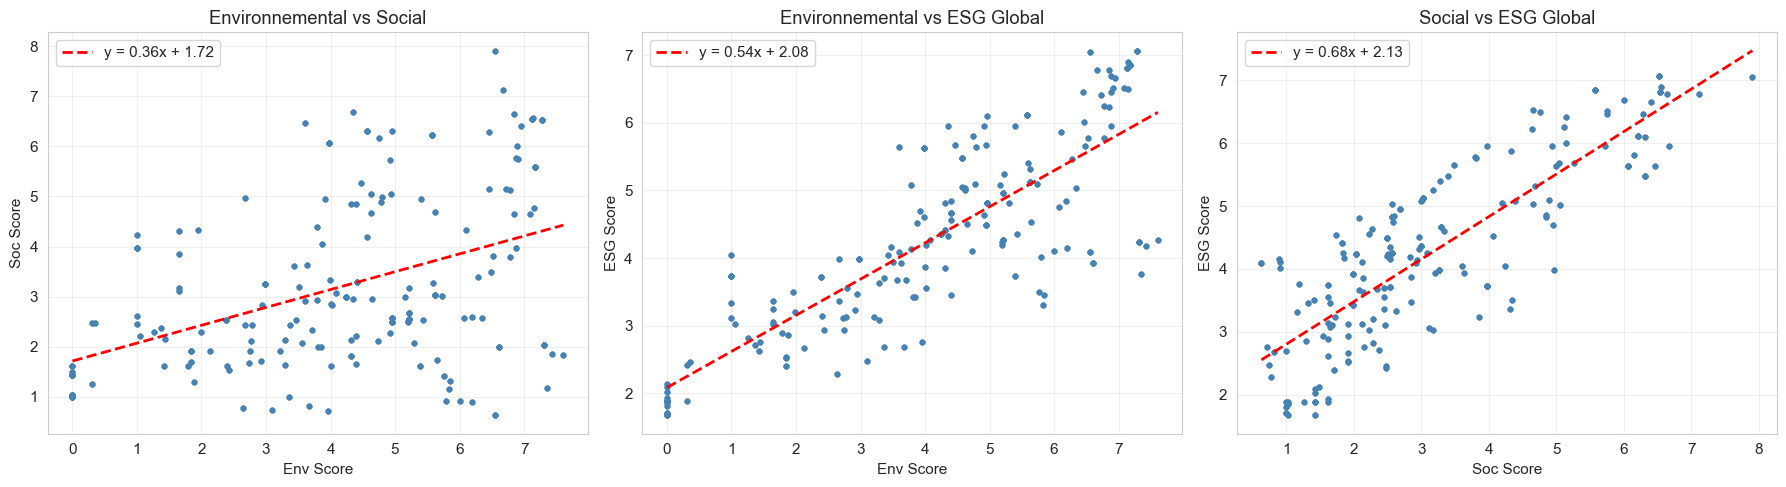

In [ ]:
# Scatter plots entre les piliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [
    ('Env_Score', 'Soc_Score', 'Environnemental vs Social'),
    ('Env_Score', 'ESG_Score', 'Environnemental vs ESG Global'),
    ('Soc_Score', 'ESG_Score', 'Social vs ESG Global')
]

for ax, (x_col, y_col, title) in zip(axes, pairs):
    subset = df_panel.dropna(subset=[x_col, y_col])
    ax.scatter(subset[x_col], subset[y_col], alpha=0.3, s=10, color='steelblue')
    
    # Droite de regression
    z = np.polyfit(subset[x_col], subset[y_col], 1)
    p = np.poly1d(z)
    x_range = np.linspace(subset[x_col].min(), subset[x_col].max(), 100)
    ax.plot(x_range, p(x_range), 'r--', linewidth=2, 
            label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
    ax.set_xlabel(x_col.replace('_', ' '))
    ax.set_ylabel(y_col.replace('_', ' '))
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

 Les nuages de points avec droites de régression confirment visuellement les corrélations observées :

- **Env vs Social ** : la dispersion est large autour de la droite, 
  cohérent avec la corrélation modérée (r = 0.443). On note des entreprises avec un score 
  environnemental élevé (>6) mais un score social faible (~1-2), et inversement 
  
  => signe que les deux piliers mesurent bien des dimensions distinctes.

- **Env vs ESG Global** : les points se resserrent davantage autour 
  de la droite (r = 0.823). La pente de 0.54 indique : 
  
  => un point supplémentaire en Environmental se traduit par environ +0.5 point sur le score global.

- **Social vs ESG Global** : relation encore plus serrée (r = 0.834) 
  avec la pente la plus forte (0.68)
  
  => le pilier Social pèse légèrement plus que l'Environmental dans la construction du score global.

**Point notable :** on observe un cluster de points en bas à gauche (scores faibles sur 
les deux axes), correspondant aux entreprises récemment intégrées ou peu matures en 
reporting ESG (Snowflake, CREDO Technology, etc.). Ce groupe constitue un cluster naturel 
que l'algorithme devrait identifier.

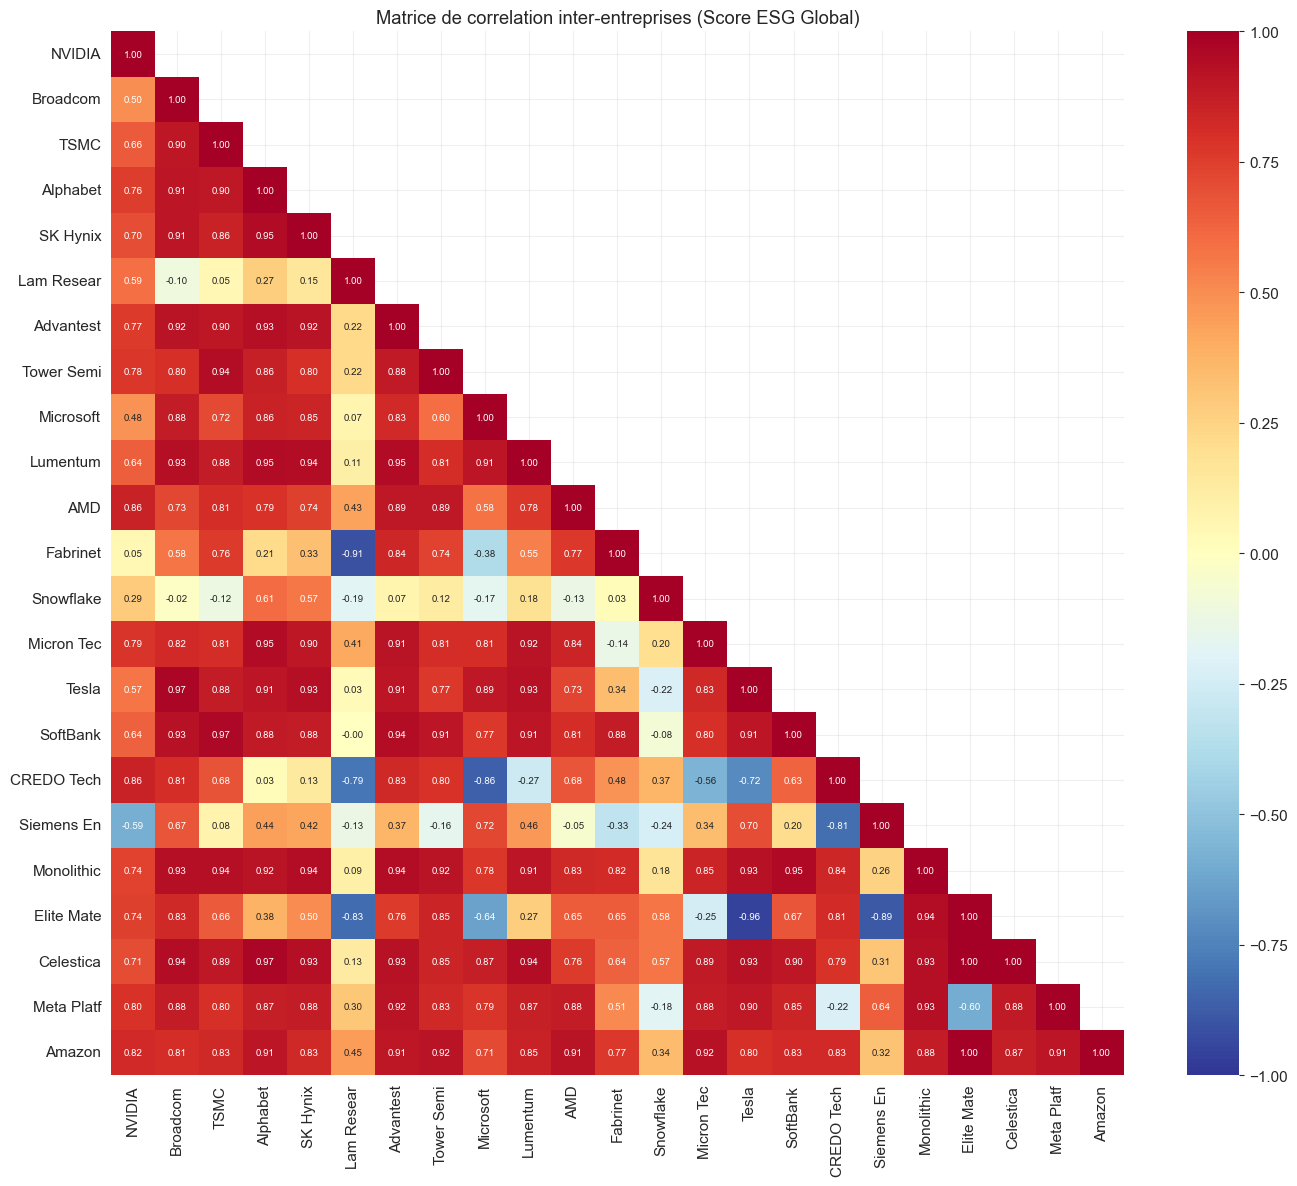

In [ ]:
# Correlation inter-entreprises (sur le score ESG global)
# Utilise le format wide : une colonne par entreprise
score_cols = [c for c in df_esg.columns if c != 'Date']
corr_entreprises = df_esg[score_cols].corr()

# Renommer pour lisibilite
short_names = [TICKER_NAMES.get(c, c).split('(')[0].strip()[:10] for c in corr_entreprises.columns]
corr_entreprises.columns = short_names
corr_entreprises.index = short_names

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_entreprises, dtype=bool), k=1)
sns.heatmap(corr_entreprises, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, annot_kws={'size': 7})
ax.set_title('Matrice de correlation inter-entreprises (Score ESG Global)')

plt.tight_layout()
plt.show()

La matrice de corrélation inter-entreprises révèle une structure claire : 

- un bloc majoritaire d'entreprises aux trajectoires ESG synchronisées (grandes capitalisations tech matures)

- plusieurs profils atypiques : 
    - entreprises récemment cotées avec un historique ESG court
    - entreprises issues de secteurs différents (énergie/industrie)

**Implication pour le clustering :**
Cette matrice suggère qu'un algorithme de clustering devrait naturellement séparer :
1. Un groupe dense de grandes tech matures (Broadcom, TSMC, Alphabet, SK Hynix...)
2. Un groupe de "retardataires" ou profils courts (Snowflake, CREDO, Lam Research)
3. Des outliers sectoriels (Siemens Energy)

Une standardisation préalable (Z-score) sera nécessaire pour 
neutraliser les effets d'échelle, et l'ACP permettra de réduire la redondance 
entre piliers avant d'appliquer les algorithmes.

---
## 9. Calcul des variations annuelles

Comme dans le paper de reference, on calcule les variations annuelles des scores ESG. 
Ces variations capturent la dynamique d'amelioration ou de degradation des pratiques ESG, 
ce qui est une information complementaire au niveau absolu du score.

On calcule la variation en difference absolue (delta) plutot qu'en pourcentage, 
car les scores BESG sont deja sur une echelle bornee [0, 10].

In [ ]:
def calculer_variations_annuelles(df_wide):
    """
    Calcule les variations annuelles (delta) pour chaque entreprise.
    On prend la difference entre le score de la meme periode d'une annee a l'autre (lag 12 mois).
    
    Parametres
    ----------
    df_wide : pd.DataFrame
        DataFrame en format wide avec colonne 'Date' et colonnes de scores.
    
    Retourne
    --------
    pd.DataFrame
        DataFrame des variations annuelles, meme format.
    """
    score_cols = [c for c in df_wide.columns if c != 'Date']
    df_var = df_wide.copy()
    
    for col in score_cols:
        df_var[col] = df_wide[col].diff(periods=12)  # Diff sur 12 mois
    
    return df_var


df_env_var = calculer_variations_annuelles(df_env)
df_soc_var = calculer_variations_annuelles(df_soc)
df_esg_var = calculer_variations_annuelles(df_esg)

# Statistiques des variations
print("Statistiques des variations annuelles du score ESG Global :")
score_cols = [c for c in df_esg_var.columns if c != 'Date']
var_stats = df_esg_var[score_cols].describe()
var_stats.columns = [TICKER_NAMES.get(c, c).split('(')[0].strip()[:12] for c in var_stats.columns]
print(var_stats.round(3).to_string())

Statistiques des variations annuelles du score ESG Global :
        NVIDIA  Broadcom     TSMC  Alphabet  SK Hynix  Lam Research  Advantest  Tower Semico  Microsoft  Lumentum      AMD  Fabrinet  Snowflake  Micron Techn    Tesla  SoftBank  CREDO Techno  Siemens Ener  Monolithic P  Elite Materi  Celestica  Meta Platfor   Amazon
count  109.000   100.000  110.000   110.000   110.000       104.000    107.000       110.000    104.000   103.000  110.000    44.000     49.000       101.000  110.000   107.000        34.000        53.000       110.000        38.000    110.000       110.000  110.000
mean     0.127     0.352    0.156     0.164     0.130         0.062      0.373         0.253      0.119     0.235    0.191     0.142     -0.002         0.223    0.216     0.170         0.279         0.052         0.279         0.145      0.348         0.213    0.269
std      0.334     0.567    0.234     0.286     0.342         0.360      0.360         0.394      0.451     0.380    0.268     0.171      0

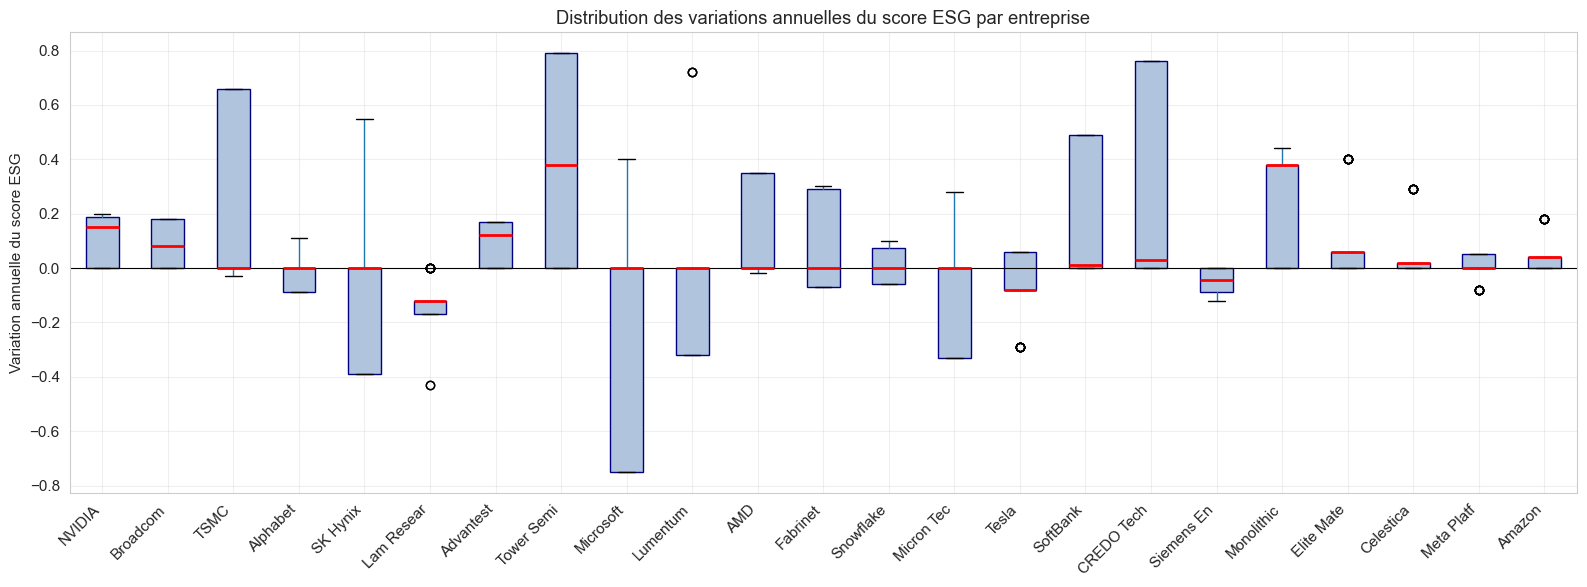

In [ ]:
# Boxplot des variations annuelles par entreprise
fig, ax = plt.subplots(figsize=(16, 6))

score_cols = [c for c in df_esg_var.columns if c != 'Date']
var_data = df_esg_var[score_cols].dropna()
var_data.columns = [TICKER_NAMES.get(c, c).split('(')[0].strip()[:10] for c in var_data.columns]

var_data.boxplot(ax=ax, vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightsteelblue', color='navy'),
                 medianprops=dict(color='red', linewidth=2))
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Variation annuelle du score ESG')
ax.set_title('Distribution des variations annuelles du score ESG par entreprise')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

La distribution des variations annuelles du score ESG met en évidence deux profils distincts :

- **Entreprises à progression stable** : NVIDIA, Broadcom, Meta Platforms ou Amazon 
  affichent des variations faibles et concentrées autour de zéro, signe d'une maturité 
  ESG avec des améliorations incrémentales.

- **Entreprises volatiles** : Tower Semi, CREDO Tech, Microsoft ou TSMC présentent 
  des amplitudes importantes (jusqu'à ±0.8 points/an), traduisant soit des rattrapages 
  rapides, soit des corrections brutales liées à des changements méthodologiques ou un 
  historique de données court.

On note également des outliers marqués (Lumentum, SK Hynix, Celestica), correspondant 
à des années de saut ou de chute ponctuelle du score.

Cette volatilité hétérogène justifie la standardisation par Z-score avant clustering, 
afin d'éviter que les entreprises les plus volatiles ne dominent la segmentation.

---
## 10. Sauvegarde des donnees nettoyees

On sauvegarde les donnees nettoyees en format CSV pour les reutiliser dans les notebooks suivants. 
Cela evite de repeter le processus de nettoyage et garantit la coherence entre les etapes.

In [ ]:
import os

# Creation des repertoires de sortie par notebook
os.makedirs('../data/clean/notebook1', exist_ok=True)
os.makedirs('../notebooks/figures', exist_ok=True)

# Sauvegarde en format wide (une colonne par entreprise)
df_env.to_csv('../data/clean/notebook1/env_score_clean.csv', index=False)
df_soc.to_csv('../data/clean/notebook1/soc_score_clean.csv', index=False)
df_esg.to_csv('../data/clean/notebook1/esg_score_clean.csv', index=False)

# Sauvegarde des variations annuelles
df_env_var.to_csv('../data/clean/notebook1/env_score_variations.csv', index=False)
df_soc_var.to_csv('../data/clean/notebook1/soc_score_variations.csv', index=False)
df_esg_var.to_csv('../data/clean/notebook1/esg_score_variations.csv', index=False)

# Sauvegarde du panel complet
df_panel.to_csv('../data/clean/notebook1/panel_complet.csv', index=False)           
print("Fichiers sauvegardes dans data/clean/01_exploration/ :")
for f in sorted(os.listdir('../data/clean/01_exploration')):
    size = os.path.getsize(f'../data/clean/01_exploration/{f}')
    print(f"  {f:40s} ({size/1024:.1f} Ko)")

Fichiers sauvegardes dans data/clean/01_exploration/ :
  env_score_clean.csv                      (13.3 Ko)
  env_score_variations.csv                 (32.1 Ko)
  esg_score_clean.csv                      (13.7 Ko)
  esg_score_variations.csv                 (37.1 Ko)
  panel_complet.csv                        (111.4 Ko)
  soc_score_clean.csv                      (13.8 Ko)
  soc_score_variations.csv                 (29.3 Ko)


---
## Synthese du Notebook 1

### Donnees
- **Panel** : 18 entreprises de la supply chain NVIDIA, 122 observations mensuelles (2016-2026)
- **Scores** : BESG Environmental Pillar, BESG Social Pillar, BESG ESG Score (composite)
- **Source** : Bloomberg Terminal

### Observations principales
- Les valeurs manquantes sont concentrees en debut de serie (left-censoring) : plusieurs entreprises n'avaient pas de score ESG avant 2017-2020
- Les scores sont sur une echelle 0-10, avec une tendance generale a la hausse sur la periode
- La dispersion entre entreprises est significative, ce qui justifie l'application de methodes de clustering
- Les correlations entre piliers Environmental et Social sont a examiner pour justifier ou non l'utilisation des deux dimensions separement

### Prochaines etapes
- **Notebook 2** : Application du K-means et du clustering hierarchique agglomeratif (CAH)
- **Notebook 3** : Ameliorations methodologiques (ACP, DBSCAN, GMM, analyse temporelle)